In [223]:
import numpy as np
import os
import PIL
import pathlib
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import cv2

import os

import numpy as np

import keras
from keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt 
import skimage
from skimage.io import imread,imsave, imshow
from skimage.color import rgb2gray
from PIL import Image
import math

In [301]:
data_dir = pathlib.Path("../BID_fomatter/")

batch_size = 32
img_height = 512
img_width = 512

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 286 files belonging to 8 classes.
Using 258 files for training.


In [303]:
data_dir_2 = pathlib.Path("../BID_fomatter_2/")

batch_size = 32
img_height = 512
img_width = 512

train_ds_2 = tf.keras.utils.image_dataset_from_directory(
    data_dir_2,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 16000 files belonging to 8 classes.
Using 14400 files for training.


# Classificador

In [225]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.metrics import accuracy_score as acc


def classification(X, y):
    """
    X é uma matriz onde cada linha corresponde aos atributos calculados com o descritor
    y são os rótulos da classe de cada imagem. Exemplo [0,1,0,0,1,2,2,0,0,0,...,1]
    """
    # separar conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
    # criar instancia do classificador
    clf = mlp(shuffle=True)
    # treinar o classificador
    clf.fit(X_train, y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test, pred)

    return acuracia


# Descritor

In [125]:
def calcula_histograma(img):
    # convertendo a imagem em array numpy
    img = np.asarray(img)

    # achatando a matriz em array 1D
    flat = img.flatten()
    # coletando o histograma com a função numpy
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 256))
    return histogram

def media_histograma(histograma):
    soma = 0
    total = 0
    for i in range(len(histograma)):
        soma += histograma[i]*i
        total += histograma[i]
    return soma/total

def variancia_histograma(histograma,media):
    soma = 0
    total = 0
    for i in range(len(histograma)):
        soma += (i-media)**2*histograma[i]
        total += histograma[i]
    return soma/total

def skewness_histograma(histograma,media,variancia):
    desvio_padrao = variancia**0.5
    soma = 0
    total = 0
    if desvio_padrao != 0:
        for i in range(len(histograma)):
            soma += ((i-media)/desvio_padrao)**3*histograma[i]
            total += histograma[i]
        return soma/total
    else:
        return 0

def kurtosis_histograma(histograma,media,variancia):
    desvio_padrao = variancia**0.5
    soma = 0
    total = 0
    if desvio_padrao != 0:
        for i in range(len(histograma)):
            soma += ((i-media)/desvio_padrao)**4*histograma[i]
            total += histograma[i]
        return soma/total-3
    else:
        return 0

def energia_histograma(histograma):
    soma = 0
    for i in range(len(histograma)):
        soma += histograma[i]**2
    return soma

def entropia_histograma(histograma):
    soma = 0
    total = sum(histograma)
    for i in range(len(histograma)):
        p = histograma[i]/total
        if p > 0:
            soma += -p*math.log2(p)
    return soma

def descritor_histograma(imagem, label):
    histograma = calcula_histograma(imagem)
    media = media_histograma(histograma)
    var = variancia_histograma(histograma,media)
    sk = skewness_histograma(histograma,media,var)
    kur = kurtosis_histograma(histograma,media,var)
    ener = energia_histograma(histograma)
    entr = entropia_histograma(histograma)

    return [media,var,sk,kur,ener,entr, label]

In [126]:
def configLabels(label):
    if y == 0 or y == 1 or y == 2:
      return 0
    elif y == 3 or y == 4:
      return 1
    elif y == 5 or y == 6 or y == 7:
      return 2


## Inicio

In [127]:
result_images = list()
for x_train, y_train in train_ds:
  for x, y in zip(x_train, y_train):
    if y == 0 or y == 1 or y == 2:
      result_images.append(descritor_histograma(x, 0))
    elif y == 3 or y == 4:
      result_images.append(descritor_histograma(x, 1))
    elif y == 5 or y == 6 or y == 7:
      result_images.append(descritor_histograma(x, 2))
    else:
      print("ERROR")

In [128]:
result_images[0]

[173.19232177734375,
 748.218874252091,
 -1.2961841204438493,
 2.0483286396382843,
 8811171794,
 6.556561224255965,
 0]

In [129]:
np.savetxt("dataset_descritor_normal.csv", result_images, delimiter=",")

In [130]:
import pandas as pd

data_frame = pd.read_csv("dataset_descritor_normal.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

In [131]:
data_frame.head()

,Media,Variancia,Skewness,Kurtosis,Energia,Entropia,Classe
0,173.192322,748.218874,-1.296184,2.048329,8.811172e+09,6.556561,0.0
1,93.453927,1976.789562,0.764032,0.203614,4.295180e+09,7.390518,1.0
2,206.209215,1230.686076,-1.292042,1.893988,6.388349e+09,6.899049,2.0
3,199.255217,983.477615,-1.829946,3.638382,9.408574e+09,6.519192,2.0
4,149.035786,877.136757,-0.704097,0.182389,6.432194e+09,6.830166,2.0


In [132]:
data_frame.to_csv('dataset_descritor_normal.csv', index=False)


In [133]:
acc_gen = classification(result_images, data_frame.Classe)
print(acc_gen)

0.46153846153846156


# Negativa

In [134]:
def negativa(imagem):
    altura, largura = imagem.shape[:2]
    for i in range(altura):
        for j in range(largura):
            imagem[i, j] = 255 - 1 - imagem[i, j]
    return imagem

def negative_s1mple(image):
    return 255 - image

In [135]:
result_images_negativa = list()
for x_train, y_train in train_ds:
  for x, y in zip(x_train, y_train):
    result_images_negativa.append(descritor_histograma(
        negativa(rgb2gray(x)), configLabels(y)))


In [136]:
np.savetxt("result_images_negativa.csv", result_images_negativa, delimiter=",")

import pandas as pd

data_frame = pd.read_csv("result_images_negativa.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

data_frame.to_csv('result_images_negativa.csv', index=False)

In [137]:
for x in range(5):
    print(result_images_negativa[x])

[138.65899276733398, 1108.1658757799162, -1.3190586428485547, 0.46362654209846754, 2521509642, 5.778500006321897, 1]
[34.15326992090868, 1396.6665926876783, 1.9098356610428835, 3.2426429040908573, 1465826141, 6.2216642976310546, 0]
[80.53840255737305, 1271.1586433466148, 1.3574006279300057, 1.3442364472100712, 978360558, 6.627516082271202, 2]
[63.380645751953125, 279.7076326152309, 1.6691186680295504, 2.0241702251501508, 2407598984, 5.43392703756279, 2]
[28.78381800120761, 1508.0888645720847, 2.2498844241492444, 5.2947528838572175, 1697451321, 6.044369944756346, 0]


In [231]:
acc_gen = classification(result_images_negativa, data_frame.Classe)
print(acc_gen)

0.3717948717948718


# Logarítmico

In [222]:
import math

def logaritmica(c,r):
    return c * np.log(1 + r)


def log_aplicada(imagem):
    c = 255 / np.log(1 + np.max(imagem))
    # Cria uma imagem resultado com o mesmo shape da imagem de entrada
    result = np.empty_like(imagem)
    
    altura, largura = imagem.shape[:2]
    for i in range(altura):
        for j in range(largura):
            result[i, j] = logaritmica(c, imagem[i][j])
    return cv2.normalize(src=result, dst=None, alpha=0,
                        beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


In [140]:
# for x in range(5):
#     plt.figure(figsize=(10,10))
#     plt.subplot(4,4,1)
#     plt.imshow(rgb2gray(x_train[x]), cmap='gray')
#     plt.subplot(4,4,2)
#     plt.imshow(log_aplicada(rgb2gray(x_train[x])), cmap='gray')

# result_images_negativa = list()
# for x_train, y_train in train_ds:
#   for x, y in zip(x_train, y_train):
#     plt.figure(figsize=(10,10))
#     plt.subplot(4,4,1)
#     plt.imshow(rgb2gray(x), cmap='gray')
#     plt.subplot(4,4,2)
#     plt.imshow(log_aplicada(rgb2gray(x)), cmap='gray')
#     break

result_images_log = list()
for x_train, y_train in train_ds:
  for x, y in zip(x_train, y_train):
    result_images_log.append(descritor_histograma(
        log_aplicada(rgb2gray(x)), configLabels(y)))


Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi
Oi


In [141]:
result_images_log[0]


[236.7771759033203,
 222.52753600641165,
 -2.0457042014126596,
 7.724698390041578,
 2106870860,
 5.439584431194821,
 0]

In [142]:
np.savetxt("result_images_log.csv", result_images_log, delimiter=",")

In [143]:
import pandas as pd

data_frame = pd.read_csv("result_images_log.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

In [144]:
data_frame.to_csv('result_images_log.csv', index=False)

In [229]:
acc_gen = classification(result_images_log, data_frame.Classe)
print(acc_gen)


0.3076923076923077


# Alargamento de contraste

In [204]:
def alargamento_de_contraste(imagem, k, e):
    altura, largura = imagem.shape

    # Aplica a função de atenuação para cada pixel da imagem
    for i in range(altura):
        for j in range(largura):
            if (imagem[i, j] != 0):
                imagem[i, j] = 1/(1+((k/imagem[i, j])**e))
            else:
                imagem[i, j] = 0
    return cv2.normalize(src=imagem, dst=None, alpha=0,
                         beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [205]:
# imagem1 = imread("../BID_fomatter/CNH_Aberta/00000000_in.jpg")
# imagem = rgb2gray(imagem1)

# # exmplo de aplicação do alargamento de contraste
# imagem_com_contraste_alargado = alargamento_de_contraste(imagem, 0.5, 1)

# #imsave("img.jpg",imagem_com_contraste_alargado)

# imshow(rgb2gray(imagem1), cmap="gray")
# plt.show()
# imshow(imagem_com_contraste_alargado, cmap="gray")


### k = 1 - e = 2

In [206]:
result_images_ac_12 = list()
for x_train, y_train in train_ds:
  for x, y in zip(x_train, y_train):
    result_images_ac_12.append(descritor_histograma(
        alargamento_de_contraste(rgb2gray(x), 1, 2), configLabels(y)))


In [207]:
for x in range(5):
    print(result_images_ac_12[x])

[211.04661178588867, 927.3256967566995, -1.4118711522625027, 1.1208805804506534, 3056973732, 5.566910110378856, 1]
[254.99130249023438, 1.1265036379918456, -205.00370225192665, 44366.23050471755, 68526725490, 0.01846279707147999, 0]
[254.9800033569336, 0.7167250732309185, -202.1459839870368, 54343.75178487829, 67926166002, 0.06556930450117263, 0]
[248.58840560913086, 76.07388000491487, -6.06070669518899, 65.9708670496995, 9834125216, 3.7139966942095772, 0]
[254.98712921142578, 0.4625342329381965, -237.18974809289702, 79506.00065999206, 68223678412, 0.043148861158492854, 0]


In [208]:
np.savetxt("result_images_ac_12.csv", result_images_ac_12, delimiter=",")

import pandas as pd

data_frame = pd.read_csv("result_images_ac_12.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

data_frame.to_csv('result_images_ac_12.csv', index=False)

In [232]:
acc_gen = classification(result_images_ac_12, data_frame.Classe)
print(acc_gen)


0.358974358974359


### k=0.4, - e=4

In [210]:
result_images_ac_044 = list()
for x_train, y_train in train_ds:
  for x, y in zip(x_train, y_train):
    result_images_ac_044.append(descritor_histograma(
        alargamento_de_contraste(rgb2gray(x), 0.4, 4), configLabels(y)))


In [211]:
for x in range(5):
    print(result_images_ac_044[x])

[0.0, 0.0, 0, 0, 68719476736, 0.0, 2]
[254.99629592895508, 0.37231217707449105, -336.88218234668045, 129293.88617620041, 68673872356, 0.005444537829951825, 0]
[254.99320602416992, 0.39651832553499844, -289.7397310971155, 106987.24765034748, 68494818440, 0.021094841537227446, 1]
[254.99462127685547, 0.486680664063897, -254.75286741438214, 79088.08667642632, 68665489006, 0.005998936410135557, 0]
[254.88245010375977, 7.762926864423207, -25.79068282681178, 826.5824669039986, 68468272662, 0.019506130507938667, 2]


In [212]:
np.savetxt("result_images_ac_044.csv", result_images_ac_12, delimiter=",")

import pandas as pd

data_frame = pd.read_csv("result_images_ac_044.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

data_frame.to_csv('result_images_ac_044.csv', index=False)

In [234]:
acc_gen = classification(result_images_ac_044, data_frame.Classe)
print(acc_gen)


0.34615384615384615


### k=1, e=16

In [214]:
result_images_ac_116 = list()
for x_train, y_train in train_ds:
  for x, y in zip(x_train, y_train):
    result_images_ac_116.append(descritor_histograma(
        alargamento_de_contraste(rgb2gray(x), 1, 16), configLabels(y)))


In [215]:
for x in range(5):
    print(result_images_ac_116[x])

[0.0, 0.0, 0, 0, 68719476736, 0.0, 1]
[0.0, 0.0, 0, 0, 68719476736, 0.0, 0]
[0.0, 0.0, 0, 0, 68719476736, 0.0, 2]
[254.998291015625, 0.38158124685287476, -374.1731799958822, 142806.2129347088, 68717903884, 0.00022250389235332752, 0]
[0.0, 0.0, 0, 0, 68719476736, 0.0, 2]


In [216]:
np.savetxt("result_images_ac_116.csv", result_images_ac_12, delimiter=",")

import pandas as pd

data_frame = pd.read_csv("result_images_ac_116.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

data_frame.to_csv('result_images_ac_116.csv', index=False)

In [235]:
acc_gen = classification(result_images_ac_116, data_frame.Classe)
print(acc_gen)


0.3974358974358974


In [297]:
epochs = 10

acc_gen=0
for x in range(epochs):
    acc_gen += classification(result_images_ac_116, data_frame.Classe)
print(acc_gen/epochs)


0.3717948717948718


### k=0.1, e=6

In [218]:
result_images_ac_016 = list()
for x_train, y_train in train_ds:
  for x, y in zip(x_train, y_train):
    result_images_ac_016.append(descritor_histograma(
        alargamento_de_contraste(rgb2gray(x), 0.1, 6), configLabels(y)))


In [219]:
for x in range(5):
    print(result_images_ac_016[x])

[254.99520874023438, 1.1820525443181396, -229.77696786079846, 52919.57473387686, 68713709724, 0.0007548115252941485, 0]
[0.0, 0.0, 0, 0, 68719476736, 0.0, 1]
[0.0, 0.0, 0, 0, 68719476736, 0.0, 2]
[254.99742889404297, 0.4674921687110327, -309.41423828072993, 102476.34895424084, 68716331050, 0.0004450075957587093, 0]
[0.0, 0.0, 0, 0, 68719476736, 0.0, 2]


In [220]:
np.savetxt("result_images_ac_016.csv", result_images_ac_12, delimiter=",")

import pandas as pd

data_frame = pd.read_csv("result_images_ac_016.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

data_frame.to_csv('result_images_ac_016.csv', index=False)

In [282]:
epochs = 100

acc_gen=0
for x in range(epochs):
    acc_gen += classification(result_images_ac_016, data_frame.Classe)
print(acc_gen/epochs)


0.3373076923076922


# Potencia

### Y = 3

In [187]:
def potencia(imagem, c, y):
    altura, largura = imagem.shape[:2]
    result = np.empty_like(imagem)
    for i in range(altura):
        for j in range(largura):
            result[i, j] = c*(imagem[i, j] ** y)
    return cv2.normalize(src=result, dst=None, alpha=0,
                         beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


In [188]:
result_images_p_3 = list()
for x_train, y_train in train_ds:
  for x, y in zip(x_train, y_train):
    result_images_p_3.append(descritor_histograma(
        potencia(rgb2gray(x), 1, 3), configLabels(y)))


In [189]:
for x in range(5):
    print(result_images_p_3[x])

[7.519775390625, 369.63072007894516, 5.4932256509773, 34.069444601821964, 15829376274, 2.8820096371865316, 1]
[166.9518814086914, 4446.951274994233, -0.9730364344082902, -0.43225516695930777, 646036922, 7.280738430370144, 2]
[158.78972244262695, 2787.355018120593, -1.4042145551336942, 1.4480021202445927, 659310888, 7.155232486612939, 2]
[94.93040084838867, 2345.6311689891013, -0.12302191184901846, -1.0971935226811185, 479178152, 7.353947352020525, 0]
[43.10957717895508, 1419.5793815442448, 1.7219461943677292, 3.6342121616775316, 1169935806, 6.582630920049109, 1]


In [190]:
np.savetxt("result_images_p_3.csv", result_images_p_3, delimiter=",")

import pandas as pd

data_frame = pd.read_csv("result_images_p_3.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

data_frame.to_csv('result_images_p_3.csv', index=False)

In [244]:
acc_gen = classification(result_images_p_3, data_frame.Classe)
print(acc_gen)


0.3974358974358974


### Y = 4

In [192]:
result_images_p_4 = list()
for x_train, y_train in train_ds:
  for x, y in zip(x_train, y_train):
    result_images_p_4.append(descritor_histograma(
        potencia(rgb2gray(x), 1, 3), configLabels(y)))


In [193]:
for x in range(5):
    print(result_images_p_4[x])

[135.07477188110352, 4478.159993730006, -0.5901991898259948, -1.0601104973418896, 427417648, 7.54965337958442, 2]
[196.96103286743164, 6137.537463953931, -1.187764615592676, -0.1297029193300454, 1905077064, 6.496399438096501, 0]
[43.3473014831543, 904.4670853846325, 3.1342641750263978, 10.314486139671228, 2173416942, 5.735485834884172, 1]
[43.160736083984375, 1945.3352707838637, 3.2909551242837045, 10.642153708684093, 2315795054, 5.748901941912289, 1]
[110.28839874267578, 1752.5143450861203, -1.0662073612787037, 0.22995342129050655, 761780790, 6.915514477077037, 2]


In [194]:
np.savetxt("result_images_p_4.csv", result_images_p_4, delimiter=",")

import pandas as pd

data_frame = pd.read_csv("result_images_p_4.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

data_frame.to_csv('result_images_p_4.csv', index=False)

In [290]:
epochs = 100

acc_gen=0
for x in range(epochs):
    acc_gen += classification(result_images_p_4, data_frame.Classe)
print(acc_gen/epochs)


0.3356410256410254


### Y = 5

In [196]:
result_images_p_5 = list()
for x_train, y_train in train_ds:
  for x, y in zip(x_train, y_train):
    result_images_p_5.append(descritor_histograma(
        potencia(rgb2gray(x), 1, 3), configLabels(y)))


In [197]:
for x in range(5):
    print(result_images_p_5[x])

[52.37501525878906, 989.1893806455184, 3.005718255019548, 9.77185750187584, 1973471222, 5.886973074942404, 1]
[168.09656143188477, 5537.739161455057, -0.6973581180294706, -0.8273911087567369, 415775544, 7.693813325438873, 2]
[94.93040084838867, 2345.6311689891013, -0.12302191184901846, -1.0971935226811185, 479178152, 7.353947352020525, 0]
[124.44744491577148, 4698.50448588793, -0.5500418572585031, -0.9024649239772882, 473258834, 7.533133835436592, 0]
[5.549877166748047, 381.08708136003435, 5.206299026391576, 30.31493932775711, 25668657386, 2.3486896509571262, 1]


In [198]:
np.savetxt("result_images_p_5.csv", result_images_p_5, delimiter=",")

import pandas as pd

data_frame = pd.read_csv("result_images_p_5.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

data_frame.to_csv('result_images_p_5.csv', index=False)

In [247]:
acc_gen = classification(result_images_p_5, data_frame.Classe)
print(acc_gen)


0.34615384615384615


### Y = 0.4

In [200]:
result_images_p_04 = list()
for x_train, y_train in train_ds:
  for x, y in zip(x_train, y_train):
    result_images_p_04.append(descritor_histograma(
        potencia(rgb2gray(x), 1, 3), configLabels(y)))


In [201]:
for x in range(5):
    print(result_images_p_04[x])

[90.54029846191406, 1227.739571712679, -0.26058918091374234, 0.22853896490664516, 632505876, 7.077995116423331, 0]
[137.1063232421875, 4121.076364740731, -0.8638424961364579, -0.8400632061602429, 919861948, 6.9062233540461495, 2]
[108.19929504394531, 3942.8049317540117, 0.028052422923255105, -0.9105525408216271, 334226424, 7.810377765210015, 0]
[184.45494079589844, 4707.648200075841, -1.3938964514078738, 0.5582066088914699, 740271160, 7.161581514649816, 0]
[148.2836036682129, 2110.143754902977, -1.249694260105124, 0.8691081602779778, 652644234, 7.142208209307072, 2]


In [202]:
np.savetxt("result_images_p_04.csv", result_images_p_04, delimiter=",")

import pandas as pd

data_frame = pd.read_csv("result_images_p_04.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

data_frame.to_csv('result_images_p_04.csv', index=False)

In [252]:
acc_gen = classification(result_images_p_04, data_frame.Classe)
print(acc_gen)


0.34615384615384615


# Plots

In [253]:
def PlotScatterMatrix(df1, df2):
    ax = pd.plotting.scatter_matrix(df1, alpha=0.2, figsize=(6,6), diagonal='kde')
    pd.plotting.scatter_matrix(df2, alpha=0.2, figsize=(6,6), diagonal='kde', ax=ax)
    
    plt.show()

In [254]:
import pandas as pd

data_frame = pd.read_csv("dataset_descritor_normal.csv", sep=',')

In [255]:
data_frame.head()

,Media,Variancia,Skewness,Kurtosis,Energia,Entropia,Classe
0,173.192322,748.218874,-1.296184,2.048329,8.811172e+09,6.556561,0.0
1,93.453927,1976.789562,0.764032,0.203614,4.295180e+09,7.390518,1.0
2,206.209215,1230.686076,-1.292042,1.893988,6.388349e+09,6.899049,2.0
3,199.255217,983.477615,-1.829946,3.638382,9.408574e+09,6.519192,2.0
4,149.035786,877.136757,-0.704097,0.182389,6.432194e+09,6.830166,2.0


In [256]:
data_frame0 = data_frame[data_frame['Classe'] == 0]
data_frame1 = data_frame[data_frame['Classe'] == 1]
data_frame2 = data_frame[data_frame['Classe'] == 2]

In [257]:
data_frame0 = data_frame0.drop('Classe', axis=1)
data_frame1 = data_frame1.drop('Classe', axis=1)
data_frame2 = data_frame2.drop('Classe', axis=1)

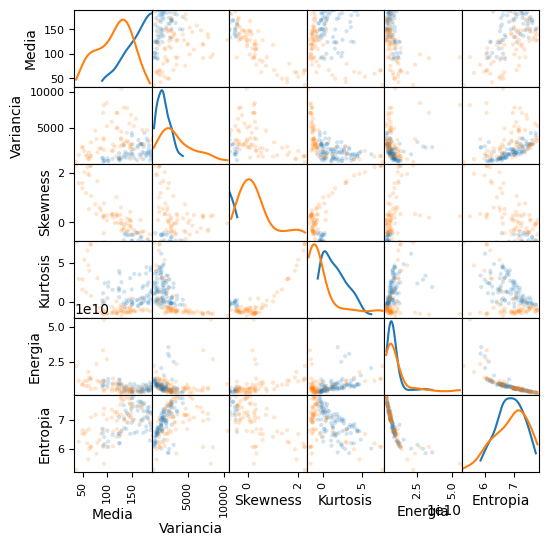

In [258]:
PlotScatterMatrix(data_frame0, data_frame1)

In [263]:
def PlotScatterMatrix_CONFUSION(df1, df2, df3):
    ax = pd.plotting.scatter_matrix(df1, alpha=0.2, figsize=(6,6), diagonal='kde')
    ax = pd.plotting.scatter_matrix(df2, alpha=0.2, figsize=(6,6), diagonal='kde', ax=ax)
    pd.plotting.scatter_matrix(df3, alpha=0.2, figsize=(6,6), diagonal='kde', ax=ax)
    
    plt.show()

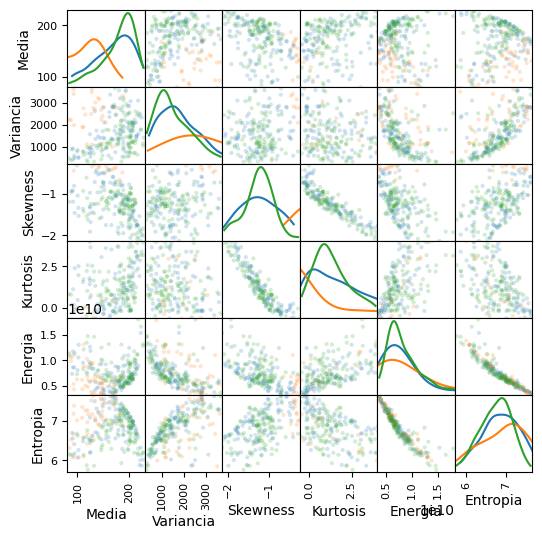

In [264]:
PlotScatterMatrix_CONFUSION(data_frame0, data_frame1, data_frame2)

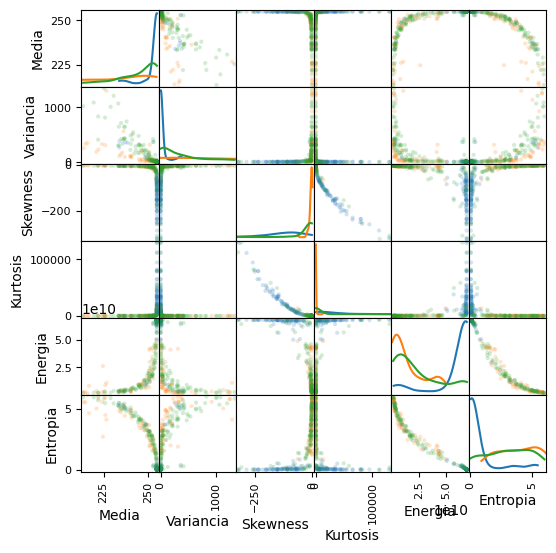

In [292]:
import pandas as pd

data_frame = pd.read_csv("result_images_ac_116.csv", sep=',')

data_frame0 = data_frame[data_frame['Classe'] == 0]
data_frame1 = data_frame[data_frame['Classe'] == 1]
data_frame2 = data_frame[data_frame['Classe'] == 2]

data_frame0 = data_frame0.drop('Classe', axis=1)
data_frame1 = data_frame1.drop('Classe', axis=1)
data_frame2 = data_frame2.drop('Classe', axis=1)

PlotScatterMatrix_CONFUSION(data_frame0, data_frame1, data_frame2)

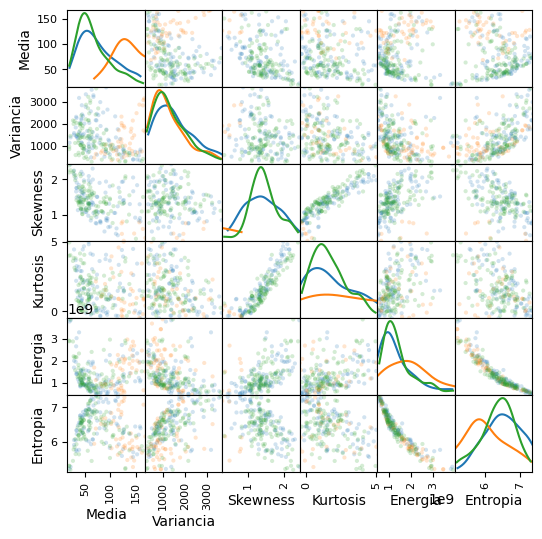

In [266]:
import pandas as pd

data_frame = pd.read_csv("result_images_negativa.csv", sep=',')

data_frame0 = data_frame[data_frame['Classe'] == 0]
data_frame1 = data_frame[data_frame['Classe'] == 1]
data_frame2 = data_frame[data_frame['Classe'] == 2]

data_frame0 = data_frame0.drop('Classe', axis=1)
data_frame1 = data_frame1.drop('Classe', axis=1)
data_frame2 = data_frame2.drop('Classe', axis=1)

PlotScatterMatrix_CONFUSION(data_frame0, data_frame1, data_frame2)


## Normal

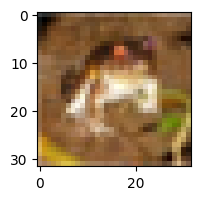

In [ ]:
for x, y in zip(x_train, y_train):
    plt.figure(figsize=(2,2))
    plt.imshow(x, cmap="gray")
    break

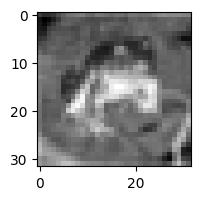

In [ ]:
for x, y in zip(x_train, y_train):
    plt.figure(figsize=(2,2))
    plt.imshow(rgb2gray(x), cmap="gray")
    break

## Negativa

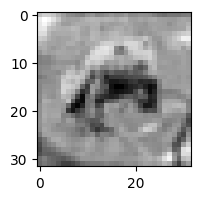

In [ ]:
for x, y in zip(x_train, y_train):
    plt.figure(figsize=(2,2))
    plt.imshow(negativa(rgb2gray(x)), cmap="gray")
    break

## Log

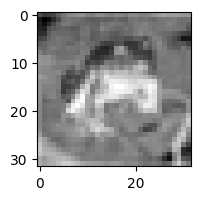

In [ ]:
for x, y in zip(x_train, y_train):
    plt.figure(figsize=(2,2))
    plt.imshow(log_aplicada(rgb2gray(x)), cmap="gray")
    break

## Alg de Contraste

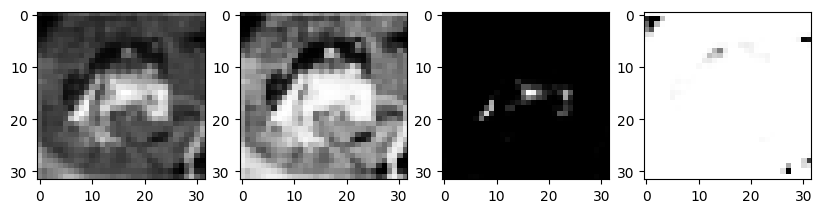

In [ ]:
for x, y in zip(x_train, y_train):
    plt.figure(figsize=(10,10))
    plt.subplot(4,4,1)
    plt.imshow(alargamento_de_contraste(rgb2gray(x), 1, 2), cmap='gray')
    plt.subplot(4,4,2)
    plt.imshow(alargamento_de_contraste(rgb2gray(x), 0.4, 4), cmap='gray')
    plt.subplot(4,4,3)
    plt.imshow(alargamento_de_contraste(rgb2gray(x), 1, 16), cmap='gray')
    plt.subplot(4,4,4)
    plt.imshow(alargamento_de_contraste(rgb2gray(x), 0.1, 6), cmap='gray')
    break

## Potencia

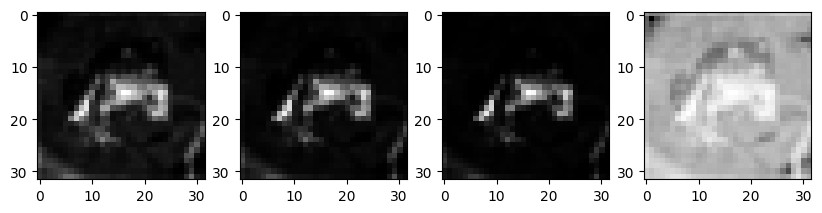

In [ ]:
for x, y in zip(x_train, y_train):
    plt.figure(figsize=(10,10))
    plt.subplot(4,4,1)
    plt.imshow(potencia(rgb2gray(x), 1, 3), cmap='gray')
    plt.subplot(4,4,2)
    plt.imshow(potencia(rgb2gray(x), 1, 4), cmap='gray')
    plt.subplot(4,4,3)
    plt.imshow(potencia(rgb2gray(x), 1, 5), cmap='gray')
    plt.subplot(4,4,4)
    plt.imshow(potencia(rgb2gray(x), 1, 0.4), cmap='gray')
    break

## Testando a quantidade de imagens

In [304]:
result_images = list()
for x_train, y_train in train_ds_2:
  for x, y in zip(x_train, y_train):
    if y == 0 or y == 1 or y == 2:
      result_images.append(descritor_histograma(x, 0))
    elif y == 3 or y == 4:
      result_images.append(descritor_histograma(x, 1))
    elif y == 5 or y == 6 or y == 7:
      result_images.append(descritor_histograma(x, 2))
    else:
      print("ERROR")


In [305]:
import pandas as pd

np.savetxt("dataset_descritor_normal.csv", result_images, delimiter=",")

data_frame = pd.read_csv("dataset_descritor_normal.csv", sep=',',
                         names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia', "Classe"])

data_frame.to_csv('dataset_descritor_normal.csv', index=False)


acc_gen = classification(result_images, data_frame.Classe)
print(acc_gen)


0.37546296296296294
